In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Parameters
num_sellers = 30
num_buyers = 100
generations = 50
mutation_rate = 0.1
price_bounds = (1, 100)
cost_bounds = (5, 50)  # Each seller has a cost drawn from here

In [3]:
# Initialize seller strategies and fixed costs
seller_prices = np.random.uniform(*price_bounds, size=num_sellers)
seller_costs = np.random.uniform(*cost_bounds, size=num_sellers)

In [4]:
# Buyers' max willingness to pay (heterogeneous demand)
buyer_wtp = np.random.normal(50, 15, size=num_buyers)
buyer_wtp = np.clip(buyer_wtp, 1, 100)  # Clamp within bounds

price_history = []

def bounded_rational_choice(prices, wtp):
    """
    Buyers pick among affordable sellers with a softmax probability.
    """
    affordable = np.where(prices <= wtp)[0]
    if len(affordable) == 0:
        return None  # No purchase
    utilities = -prices[affordable]  # Lower price = higher utility
    probs = np.exp(utilities - np.max(utilities))  # Softmax trick
    probs /= probs.sum()
    return np.random.choice(affordable, p=probs)

def simulate_market(seller_prices, seller_costs):
    buyer_choices = []
    for buyer_idx in range(num_buyers):
        wtp = buyer_wtp[buyer_idx]
        chosen = bounded_rational_choice(seller_prices, wtp)
        buyer_choices.append(chosen)

    # Count how many buyers each seller got
    sales = np.zeros(num_sellers)
    for choice in buyer_choices:
        if choice is not None:
            sales[choice] += 1

    revenue = seller_prices * sales
    costs = seller_costs * sales
    profit = revenue - costs
    return sales, profit

In [5]:
# Variables to store the top strategies from the previous generation for memory
prev_top_prices = None
prev_top_costs = None

In [6]:
# Evolutionary loop
for generation in range(generations):
    # Simulate market with current seller strategies
    sales, profit = simulate_market(seller_prices, seller_costs)

    # Selection: keep top half by profit
    top_indices = profit.argsort()[-(num_sellers // 2):]
    top_prices = seller_prices[top_indices]
    top_costs = seller_costs[top_indices]

    # Memory Update: Apply learning to the selected top sellers
    # For generation 0, there is no previous memory so we skip this update.
    if prev_top_prices is not None and prev_top_costs is not None:
        top_prices = 0.7 * top_prices + 0.3 * prev_top_prices
        top_costs  = 0.7 * top_costs  + 0.3 * prev_top_costs

    # Save current top strategies for the next generation's memory update
    prev_top_prices = top_prices.copy()
    prev_top_costs  = top_costs.copy()

    # Reproduction: Generate new seller strategies using crossover and mutation.
    # Parent selection now ensures two distinct parents are chosen.
    new_prices = []
    new_costs = []
    while len(new_prices) < num_sellers:
        i, j = np.random.choice(len(top_prices), size=2, replace=False)
        p1, p2 = top_prices[i], top_prices[j]
        c1, c2 = top_costs[i], top_costs[j]

        # Crossover: average the parent's values.
        child_price = (p1 + p2) / 2
        child_cost = (c1 + c2) / 2

        # Mutation: perturb the child's attributes with a given probability.
        if np.random.rand() < mutation_rate:
            child_price += np.random.normal(0, 5)
        if np.random.rand() < mutation_rate:
            child_cost += np.random.normal(0, 3)

        child_price = np.clip(child_price, *price_bounds)
        child_cost = np.clip(child_cost, *cost_bounds)

        new_prices.append(child_price)
        new_costs.append(child_cost)

    # Update sellers for the next generation
    seller_prices = np.array(new_prices)
    seller_costs = np.array(new_costs)
    price_history.append(seller_prices.copy())

    print(f"Gen {generation+1:02}: Avg Price = {seller_prices.mean():.2f}, "
          f"Avg Cost = {seller_costs.mean():.2f}, Max Profit = {profit.max():.2f}")

Gen 01: Avg Price = 54.55, Avg Cost = 29.58, Max Profit = 0.00
Gen 02: Avg Price = 55.87, Avg Cost = 30.42, Max Profit = 1455.20
Gen 03: Avg Price = 53.41, Avg Cost = 29.96, Max Profit = 1423.96
Gen 04: Avg Price = 54.64, Avg Cost = 31.03, Max Profit = 1204.31
Gen 05: Avg Price = 53.06, Avg Cost = 30.57, Max Profit = 424.27
Gen 06: Avg Price = 52.22, Avg Cost = 30.53, Max Profit = 752.89
Gen 07: Avg Price = 52.28, Avg Cost = 30.46, Max Profit = 850.90
Gen 08: Avg Price = 52.29, Avg Cost = 29.96, Max Profit = 856.78
Gen 09: Avg Price = 51.34, Avg Cost = 29.21, Max Profit = 437.95
Gen 10: Avg Price = 50.93, Avg Cost = 29.40, Max Profit = 539.01
Gen 11: Avg Price = 49.59, Avg Cost = 29.28, Max Profit = 633.01
Gen 12: Avg Price = 49.03, Avg Cost = 29.04, Max Profit = 934.21
Gen 13: Avg Price = 48.33, Avg Cost = 29.39, Max Profit = 94.52
Gen 14: Avg Price = 47.52, Avg Cost = 29.72, Max Profit = 366.42
Gen 15: Avg Price = 46.76, Avg Cost = 29.45, Max Profit = 552.65
Gen 16: Avg Price = 45.78

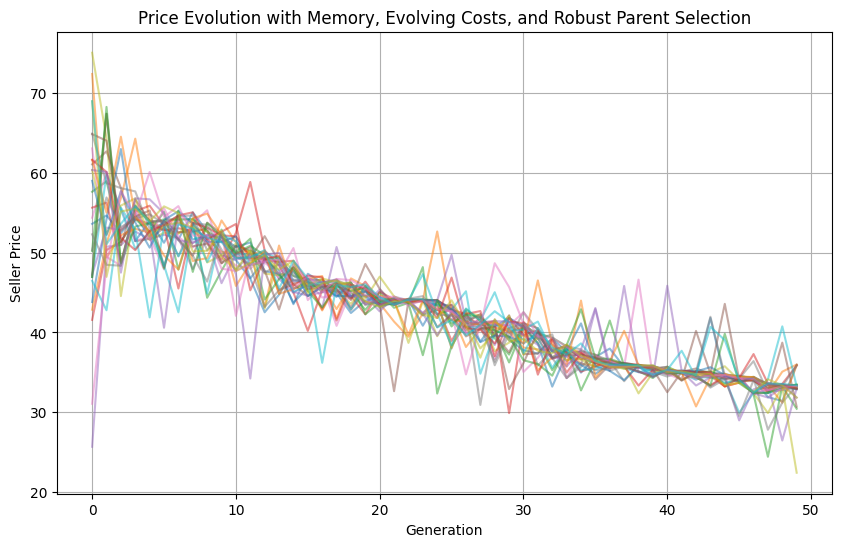

In [7]:
# Plot price trajectories
price_history = np.array(price_history)
plt.figure(figsize=(10, 6))
for i in range(num_sellers):
    plt.plot(price_history[:, i], alpha=0.5)
plt.title("Price Evolution with Memory, Evolving Costs, and Robust Parent Selection")
plt.xlabel("Generation")
plt.ylabel("Seller Price")
plt.grid(True)
plt.show()